# Pruning and Distillation of Llama 3.1 model with NeMo Framework

This notebook showcases performing pruning and distillation on **Llama 3.1-8B-Instruct** with the [WikiText-103-v1](https://huggingface.co/datasets/Salesforce/wikitext/viewer/wikitext-103-v1) dataset using NeMo Framework. The [WikiText-103-v1](https://huggingface.co/datasets/Salesforce/wikitext/viewer/wikitext-103-v1) language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. 

For this demonstration, we will perform a light finetuning procedure on the `Meta Llama 3.1 8B Instruct` teacher model to generate a finetuned teacher model. This finetuned teacher model will then be trimmed to create a depth-pruned model `4b_trimmed_model.nemo` that will serve as a starting point for distillation to a final 4B model. 

> We are using models utilizing the `meta-llama/Meta-Llama-3.1-8B` tokenizer for this demonstration.

> `NOTE:` Ensure that you run this notebook inside the [NeMo Framework container](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/nemo) which has all the required dependencies. 

**Instructions are available in the associated tutorial README to download the model and the container.**

In [ ]:
!pip install --upgrade ipywidgets notebook
!pip install datasets

---
## Prerequisites
Ensure you have the following -
1. **Get the teacher model**: Download the `Meta Llama 3.1 8B Instruct .nemo` model. You must follow the instructions in the associated README to download and mount the folder to the NeMo FW container.

In [ ]:
!ls /workspace/llama-3_1-8b-instruct-nemo_v1.0

2. **Set the Hugging Face Access Token**: You can obtain this from your [Hugging Face account](https://huggingface.co/docs/hub/en/security-tokens). 

In [ ]:
from huggingface_hub import login
login(token="<YOUR_HF_ACCESS_TOKEN>")

3. **Obtain the dataset**: Generate the `wikitext-{train/val/test}.jsonl` splits after loading the [WikiText-103-v1](https://huggingface.co/datasets/Salesforce/wikitext/viewer/wikitext-103-v1) dataset.

In [ ]:
# Split into train, test and val files

import json
import os
from datasets import load_dataset

# Load the WikiText-103 dataset
dataset = load_dataset("wikitext", "wikitext-103-v1")

# Define the destination folder
data_folder = 'wikitext-data'
os.makedirs(data_folder, exist_ok=True)

# Define file paths and destination paths
file_paths = {
    'train': os.path.join(data_folder, 'wikitext-train.jsonl'),
    'validation': os.path.join(data_folder, 'wikitext-val.jsonl'),
    'test': os.path.join(data_folder, 'wikitext-test.jsonl')
}

# Function to save dataset split to a JSONL file
def save_to_jsonl(file_path, data):
    with open(file_path, 'w') as file:
        for item in data:
            file.write(json.dumps(item) + '\n')

# Define splits
splits = ["train", "validation", "test"]

# Save splits to JSONL files and calculate their sizes
for split in splits:
    if split in dataset:
        save_to_jsonl(file_paths[split], dataset[split])
    else:
        print(f"Split {split} not found in the dataset.")


---
##  Step-by-step instructions

This notebook is structured into five steps:
1. Prepare the dataset
2. Finetune the teacher on the dataset
3. Prune the finetuned-teacher model to create a student
3. Distill knowledge from teacher into student
4. Display the validation loss

### Step 1: Prepare the dataset

The dataset has to be preprocessed using the [preprocess_data_for_megatron.py](https://github.com/NVIDIA/NeMo/blob/main/scripts/nlp_language_modeling/preprocess_data_for_megatron.py) script included in the NeMo Framework. This step will also tokenize data using the `meta-llama/Meta-Llama-3.1-8B` tokenizer model to convert the data into a memory map format.

> `NOTE:` In the block of code below, pass the paths to your train, test and validation data files.

In [ ]:
!python /opt/NeMo/scripts/nlp_language_modeling/preprocess_data_for_megatron.py \
--input="./wikitext-data/wikitext-train.jsonl" \
--tokenizer-library='huggingface' \
--tokenizer-type='meta-llama/Meta-Llama-3.1-8B' \
--output-prefix=wikitext_tokenized_train \
--append-eod \
--workers=32

In [ ]:
!python /opt/NeMo/scripts/nlp_language_modeling/preprocess_data_for_megatron.py \
--input="./wikitext-data/wikitext-test.jsonl" \
--tokenizer-library='huggingface' \
--tokenizer-type='meta-llama/Meta-Llama-3.1-8B' \
--output-prefix=wikitext_tokenized_test \
--append-eod \
--workers=32

In [ ]:
!python /opt/NeMo/scripts/nlp_language_modeling/preprocess_data_for_megatron.py \
--input="./wikitext-data/wikitext-val.jsonl" \
--tokenizer-library='huggingface' \
--tokenizer-type='meta-llama/Meta-Llama-3.1-8B' \
--output-prefix=wikitext_tokenized_val \
--append-eod \
--workers=32

After running the above scripts, you will see the preprocesed `wikitext_tokenized_{train/val/test}_text_document.{idx/bin}`files. These output files will be used in the next step.


### Step 2: Finetune the teacher on the dataset

NeMo framework includes a standard python script [megatron_gpt_pretraining.py](https://github.com/NVIDIA/NeMo/blob/main/examples/nlp/language_modeling/megatron_gpt_pretraining.py) for training a model. Once you have your model downloaded and the dataset ready, fine-tuning the teacher model with NeMo is essentially just running this script!

For this demonstration, this training run is capped by `STEPS`, and validation is carried out every `VAL_INTERVAL` steps.

> `NOTE:` In the block of code below, pass the paths to your pre-processed train, test and validation data files as well as path to the teacher .nemo model.

In [ ]:
%%bash 

export CUDA_DEVICE_MAX_CONNECTIONS=1


# Set path(s) if different:

MODEL="/workspace/llama-3_1-8b-instruct-nemo_v1.0/llama3_1_8b_instruct.nemo"

# Can change these to accommodate resources:

TENSOR_PARALLEL_SIZE=8
NODES=1
MICRO_BATCH_SIZE=4

# Don't change the following:

EXPERIMENT_DIR="distill_trainings"
EXPERIMENT_NAME="megatron_llama_ft"

DATA_TRAIN='wikitext_tokenized_train_text_document'
DATA_VAL='wikitext_tokenized_test_text_document'
DATA_TEST='wikitext_tokenized_val_text_document'

STEPS=30
GLOBAL_BATCH_SIZE=128

LOG_INTERVAL=1
VAL_INTERVAL=10
NUM_VAL_BATCHES=5

LR=1e-4
MIN_LR=1e-5
WARMUP_STEPS=2


cmd="torchrun --nproc-per-node=${TENSOR_PARALLEL_SIZE}"

${cmd} /opt/NeMo/examples/nlp/language_modeling/megatron_gpt_pretraining.py \
    --config-path /opt/NeMo/examples/nlp/language_modeling/conf/ \
    --config-name megatron_llama_distill.yaml \
    \
    name=${EXPERIMENT_NAME} \
    \
    exp_manager.exp_dir=${EXPERIMENT_DIR} \
    exp_manager.checkpoint_callback_params.save_top_k=1 \
    exp_manager.checkpoint_callback_params.save_nemo_on_train_end=True \
    \
    trainer.max_steps=${STEPS} \
    trainer.log_every_n_steps=${LOG_INTERVAL} \
    trainer.val_check_interval=${VAL_INTERVAL} \
    trainer.limit_val_batches=${NUM_VAL_BATCHES} \
    +trainer.num_sanity_val_steps=0 \
    \
    trainer.precision=bf16 \
    trainer.devices=${TENSOR_PARALLEL_SIZE} \
    trainer.num_nodes=${NODES} \
    \
    "model.data.data_prefix={train:[1.0,$DATA_TRAIN],validation:[$DATA_VAL],test:[$DATA_TEST]}" \
    \
    model.restore_from_path=${MODEL} \
    \
    ~model.tokenizer \
    +model.tokenizer='{library: huggingface, type: meta-llama/Meta-Llama-3.1-8B, use_fast: True}' \
    \
    model.tensor_model_parallel_size=${TENSOR_PARALLEL_SIZE} \
    model.sequence_parallel=True \
    model.micro_batch_size=${MICRO_BATCH_SIZE} \
    model.global_batch_size=${GLOBAL_BATCH_SIZE} \
    \
    model.encoder_seq_length=8192 \
    model.num_layers=32 \
    model.hidden_size=4096 \
    model.ffn_hidden_size=14336 \
    model.num_attention_heads=32 \
    model.hidden_dropout=0.0 \
    model.attention_dropout=0.0 \
    model.apply_query_key_layer_scaling=True \
    model.normalization='rmsnorm' \
    model.bias=False \
    model.activation='fast-swiglu' \
    model.position_embedding_type='rope' \
    model.share_embeddings_and_output_weights=False \
    model.num_query_groups=8 \
    ++model.scale_positional_embedding=True \
    ++model.rotary_base=500000.0 \
    \
    model.optim.name=distributed_fused_adam \
    model.optim.lr=${LR} \
    model.optim.sched.min_lr=${MIN_LR} \
    model.optim.sched.warmup_steps=${WARMUP_STEPS}

This will create a finetuned teacher model named `megatron_llama_ft.nemo` in `./distill_trainings/megatron_llama_ft/checkpoints/`. We'll use this later.
> `NOTE:`This script takes at least 20 minutes to run (depending on GPU) and will generate the finetuned teacher model.

### Step 3: Prune the finetuned-teacher model to create a student

The next step is to trim the last 16 layers in the finetined teacher model. In this notebook, we are using depth-pruning and would be using the [megatron_gpt_drop_layers](https://github.com/NVIDIA/NeMo/blob/main/examples/nlp/language_modeling/megatron_gpt_drop_layers.py) script. 
> `NOTE:` In the block of code below, pass the paths to your finetuned teacher .nemo model.

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=8 \
     /opt/NeMo/examples/nlp/language_modeling/megatron_gpt_drop_layers.py \
     --path_to_nemo "./distill_trainings/megatron_llama_ft/checkpoints/megatron_llama_ft.nemo" \
     --path_to_save "/workspace/4b_trimmed_model.nemo" \
     --tensor_model_parallel_size 8 \
     --pipeline_model_parallel_size 1 \
     --gpus_per_node 8 \
     --drop_layers 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31

Running this script will save the depth-pruned model `4b_trimmed_model.nemo` to your workspace.


### Step 4: Distill knowledge from teacher into student

Distillation of a model with NeMo Framework is also possible using a python script: [megatron_gpt_distillation.py](https://github.com/NVIDIA/NeMo/blob/main/examples/nlp/language_modeling/megatron_gpt_distillation.py). 

For this demonstration, the `TEACHER` would be the finetuned teacher model `megatron_llama_ft.nemo` and the `STUDENT` model would be the pruned 4B model `4b_trimmed_model.nemo`. This training run is capped by `STEPS`, and validation is carried out every `VAL_INTERVAL` steps.

> `NOTE:` In the block of code below, pass the paths to your pre-processed train, test and validation data files as well as path to the teacher and student .nemo models.

In [ ]:
%%bash 

export CUDA_DEVICE_MAX_CONNECTIONS=1


# Can change these to accommodate resources:

TENSOR_PARALLEL_SIZE=8
NODES=1
MICRO_BATCH_SIZE=4

# Don't change the following:

EXPERIMENT_DIR="distill_trainings"
EXPERIMENT_NAME="megatron_llama_distill"

TEACHER="${EXPERIMENT_DIR}/megatron_llama_ft/checkpoints/megatron_llama_ft.nemo"
STUDENT="/workspace/4b_trimmed_model.nemo"

FINAL_MODEL_PATH="${EXPERIMENT_DIR}/${EXPERIMENT_NAME}/checkpoints/distilled_4b_model.nemo"

DATA_TRAIN='wikitext_tokenized_train_text_document'
DATA_VAL='wikitext_tokenized_test_text_document'
DATA_TEST='wikitext_tokenized_val_text_document'

STEPS=30
GLOBAL_BATCH_SIZE=128

LOG_INTERVAL=1
VAL_INTERVAL=10
NUM_VAL_BATCHES=5

LR=1e-4
MIN_LR=1e-5
WARMUP_STEPS=2


cmd="torchrun --nproc-per-node=${TENSOR_PARALLEL_SIZE}"

${cmd} /opt/NeMo/examples/nlp/language_modeling/megatron_gpt_distillation.py \
    name=${EXPERIMENT_NAME} \
    \
    exp_manager.exp_dir=${EXPERIMENT_DIR} \
    exp_manager.checkpoint_callback_params.save_top_k=1 \
    \
    trainer.max_steps=${STEPS} \
    trainer.log_every_n_steps=${LOG_INTERVAL} \
    trainer.val_check_interval=${VAL_INTERVAL} \
    trainer.limit_val_batches=${NUM_VAL_BATCHES} \
    +trainer.num_sanity_val_steps=0 \
    \
    trainer.precision=bf16 \
    trainer.devices=${TENSOR_PARALLEL_SIZE} \
    trainer.num_nodes=${NODES} \
    \
    "model.data.data_prefix={train:[1.0,$DATA_TRAIN],validation:[$DATA_VAL],test:[$DATA_TEST]}" \
    \
    model.restore_from_path=${STUDENT} \
    model.kd_teacher_restore_from_path=${TEACHER} \
    model.nemo_path=${FINAL_MODEL_PATH} \
    \
    model.tensor_model_parallel_size=${TENSOR_PARALLEL_SIZE} \
    model.sequence_parallel=True \
    model.micro_batch_size=${MICRO_BATCH_SIZE} \
    model.global_batch_size=${GLOBAL_BATCH_SIZE} \
    \
    model.optim.name=distributed_fused_adam \
    model.optim.lr=${LR} \
    model.optim.sched.min_lr=${MIN_LR} \
    model.optim.sched.warmup_steps=${WARMUP_STEPS}


This will create the final distilled model named `distilled_4b_model.nemo` in `./distill_trainings/megatron_llama_distill/checkpoints`.
> `NOTE:`This script takes at least 35 minutes to run and generate the final distilled model.

### Step 5: Display the validation loss

Now that the results are in, let's visualize the validation loss of the distilled model using the `tensorboard` library. 
> `NOTE:` This notebook demonstrates the use of the teacher finetuning, pruning and the distillation script. These scripts should ideally be run on a multi-node cluster with a larger `GLOBAL_BATCH_SIZE` and `STEPS` to see improvement in the validation loss.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "distill_trainings/megatron_llama_distill/" --port=6007

Here is an image of the validation loss over 30 steps of running the training step in the distillation script.

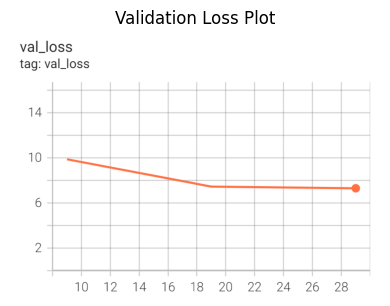

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

x0 = Image.open('./images/val_loss_distillation.png')

plt.figure(figsize=(4, 4))
plt.imshow(x0)
plt.axis('off')
plt.title('Validation Loss Plot')

# Show the image
plt.tight_layout()
plt.show()